In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
import pickle
import sklearn
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Loading data and embeddings

# label_embeddings = pickle.load(open("Data/Embeddings/CIFAR/CIFAR_100_label_to_embedding_google_news.pk", "rb"))
label_embeddings = pickle.load(open("Data/Embeddings/CIFAR/CIFAR_100_label_to_embedding_wordnet.pk", "rb"))
embedding_len = len(label_embeddings[0])

train_x = np.load("vgg_16/train_x.npy").reshape((50000,-1))
train_y = np.load("vgg_16/train_y.npy")
test_x = np.load("vgg_16/test_x.npy").reshape((10000,-1))
test_y = np.load("vgg_16/test_y.npy")

In [3]:
#Convert train/test labels to embeddings
train_y_embeddings = np.zeros((50000, embedding_len))
test_y_embeddings = np.zeros((10000, embedding_len))

for i in range(train_y.shape[0]):np.
    train_y_embeddings[i] = label_embeddings[int(train_y[i][0])]

for i in range(test_y.shape[0]):
    test_y_embeddings[i] = label_embeddings[int(test_y[i][0])]

In [4]:
model = Sequential()

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(embedding_len, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(embedding_len))

model.compile(loss='mse', optimizer='adam', metrics=['cosine_proximity'])

In [5]:
epochs = 10
batch_size = 128

model.fit(train_x, train_y_embeddings, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y_embeddings))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 49us/step - loss: 0.0529 - cosine_proximity: -0.4761 - val_loss: 0.0089 - val_cosine_proximity: -0.6373
Epoch 2/10
50000/50000 [==============================] - 2s 32us/step - loss: 0.0058 - cosine_proximity: -0.7349 - val_loss: 0.0048 - val_cosine_proximity: -0.7612
Epoch 3/10
50000/50000 [==============================] - 2s 32us/step - loss: 0.0037 - cosine_proximity: -0.8133 - val_loss: 0.0040 - val_cosine_proximity: -0.7918
Epoch 4/10
50000/50000 [==============================] - 2s 33us/step - loss: 0.0030 - cosine_proximity: -0.8442 - val_loss: 0.0038 - val_cosine_proximity: -0.8044
Epoch 5/10
50000/50000 [==============================] - 2s 32us/step - loss: 0.0027 - cosine_proximity: -0.8612 - val_loss: 0.0034 - val_cosine_proximity: -0.8173
Epoch 6/10
50000/50000 [==============================] - 2s 32us/step - loss: 0.0024 - cosine_proximity: -0.8728 - val_loss:

## Testing

In [6]:
label_embeddings_arr = np.zeros((100, embedding_len))
for i in range(100):
    label_embeddings_arr[i] = label_embeddings[i]

In [7]:
#Top K Predictions
def pred_top_k(pred_test_y, k=5, label_embeddings_arr=label_embeddings_arr):
    sim_table = cosine_similarity(pred_test_y, label_embeddings_arr)
    top_k_guesses = np.argpartition(sim_table,range(99-k+1,100),axis=1)[:,99-k+1:]
    return sim_table, top_k_guesses

pred_test_y = model.predict(test_x)
k = 5
sim_table, top_k_guesses = pred_top_k(pred_test_y, k=k)

#Top prediction
label_predictions = sim_table.argmax(axis=1)

In [8]:
#Accuracy
acc = np.sum((np.squeeze(test_y) == label_predictions)) / float(test_y.shape[0])
print("Accuracy: " + str(acc))

#Top k Accuracy
def acc(top_k=top_k_guesses, test_y=test_y):
    correct = 0
    for i in range(test_y.shape[0]):
        if np.squeeze(test_y)[i] in top_k[i]:
            correct += 1
    return correct/float(test_y.shape[0])

print("Top " + str(k) + " Accuracy: " + str(acc()))

Accuracy: 0.0981
Top 5 Accuracy: 0.3021


In [9]:
x = np.linspace(0,99,100) 
y=np.zeros(100)

for i in range(100):
    k = i+1
    s, top_k_guesses = pred_top_k(pred_test_y, k=k)
    y[i] = acc(top_k_guesses, test_y)

Text(0.5, 1.0, 'Top K Accuracy')

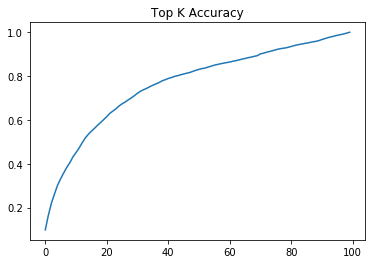

In [10]:
plt.plot(x,y)
plt.title("Top K Accuracy")